#### Read in data

In [259]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import xgboost as xgb
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.svm import SVR, NuSVR
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [260]:
def standardise(Dataframe):
    # standardises all the columns of a Dataframe
    standardised = (Dataframe - Dataframe.mean())/Dataframe.std()
    standardised =  standardised.fillna(0)
    return(standardised)

def validation_plot(y_pred, y_val):
    r2 = r2_score(y_pred, y_val)
    diff = np.round(np.mean(np.abs(y_pred-y_val)),2)
    # sort data because it's easier to interpret
    zipped = zip(y_pred, y_val)
    sorted_zipped = sorted(zipped, key=lambda x: x[1])
    y_pred, y_val = zip(*sorted_zipped)
    # plot
    x = range(0,np.size(y_pred))
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_title(f'R-squared: {r2}\nAverage year difference: {diff}')
    ax.set_xlabel('patient');
    ax.set_ylabel('age');
    ax.scatter(x, y_val);
    ax.scatter(x, y_pred, color='orange');
    ax.legend(['Observation', 'Predicted']);

In [261]:
SOMAMeta = pd.read_csv('SOMAMeta.csv')
Meta = SOMAMeta[SOMAMeta.columns[:1005]]
SOMA = SOMAMeta[SOMAMeta.columns[1005:]]
age = SOMAMeta['Age_years']

C:\Users\jeppe\AppData\Local\Temp\ipykernel_3008\809998217.py:1: DtypeWarning: Columns (14,16,17,18,19,29,33,36,38,39,41,45,46,47,48,49,50,51,52,145,146,171,615,938,939,940,941,942,943) have mixed types. Specify dtype option on import or set low_memory=False.
  SOMAMeta = pd.read_csv('SOMAMeta.csv')


find best correlated predictors

In [262]:
colnames = SOMA.columns
p_vec = []

for i in range(len(colnames)):
    pearson_corr = np.corrcoef(age, SOMA.iloc[:, i])[0, 1]
    p_vec.append(pearson_corr)

df = pd.DataFrame({'Pearson Correlation':p_vec, 'Predictor':colnames})
df = df.iloc[np.abs(df['Pearson Correlation']).argsort()[::-1]]

select n best predictors

In [263]:
n = 300
selectedP = SOMAMeta[df.iloc[0:n,1].reset_index(drop=True)]
#selectedP = SOMA.copy()

x_train, x_val, y_train, y_val = train_test_split(
    selectedP, 
    age, 
    test_size=0.2, 
    random_state=42,
    stratify = Meta['Ever_smokers']
)

x_train = standardise(x_train)
x_val = standardise(x_val)

model using selected predictors

Lasso

R-squared on traindata: 0.7609637232233938
R-squared on testdata: 0.5897561661620777


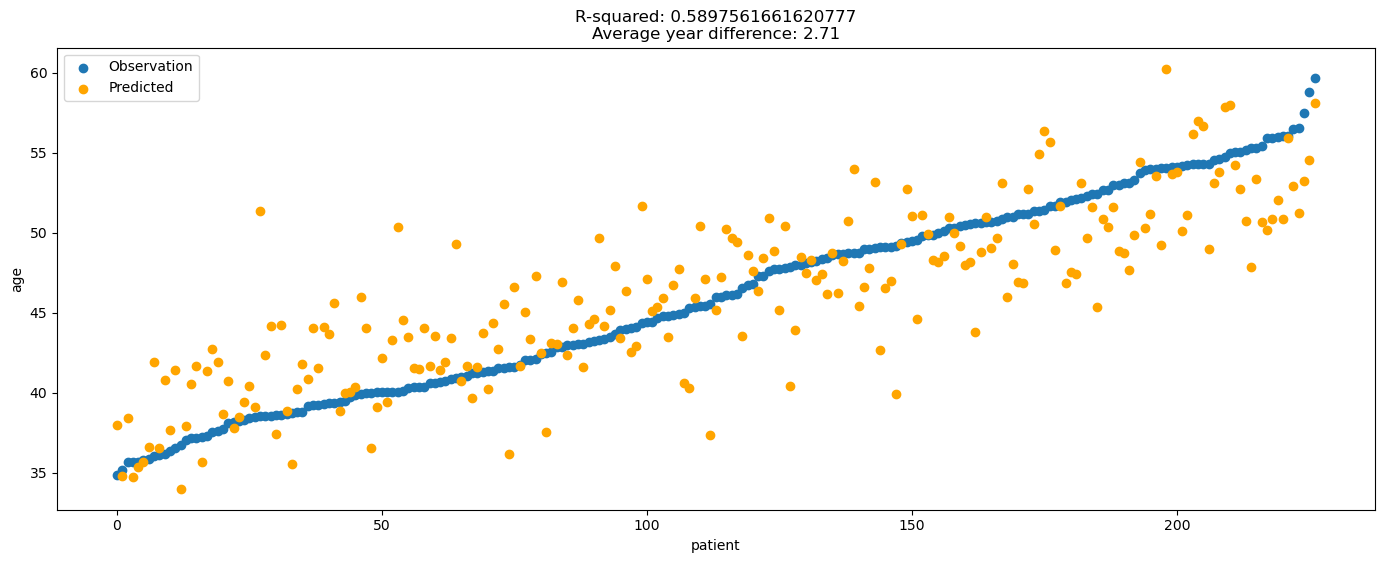

In [264]:
# Parameters found using manual hyperparamter tuning
model = LassoCV(cv=4, max_iter=10000, n_alphas=4).fit(x_train, y_train)

y_pred = model.predict(x_val)
r2_train = r2_score(model.predict(x_train), y_train)
r2_test = r2_score(y_pred, y_val)

print('R-squared on traindata:',r2_train)
print('R-squared on testdata:',r2_test)
validation_plot(y_pred, y_val)

Ridge

R-squared on traindata: 0.7910603857634354
R-squared on testdata: 0.5939946660482427


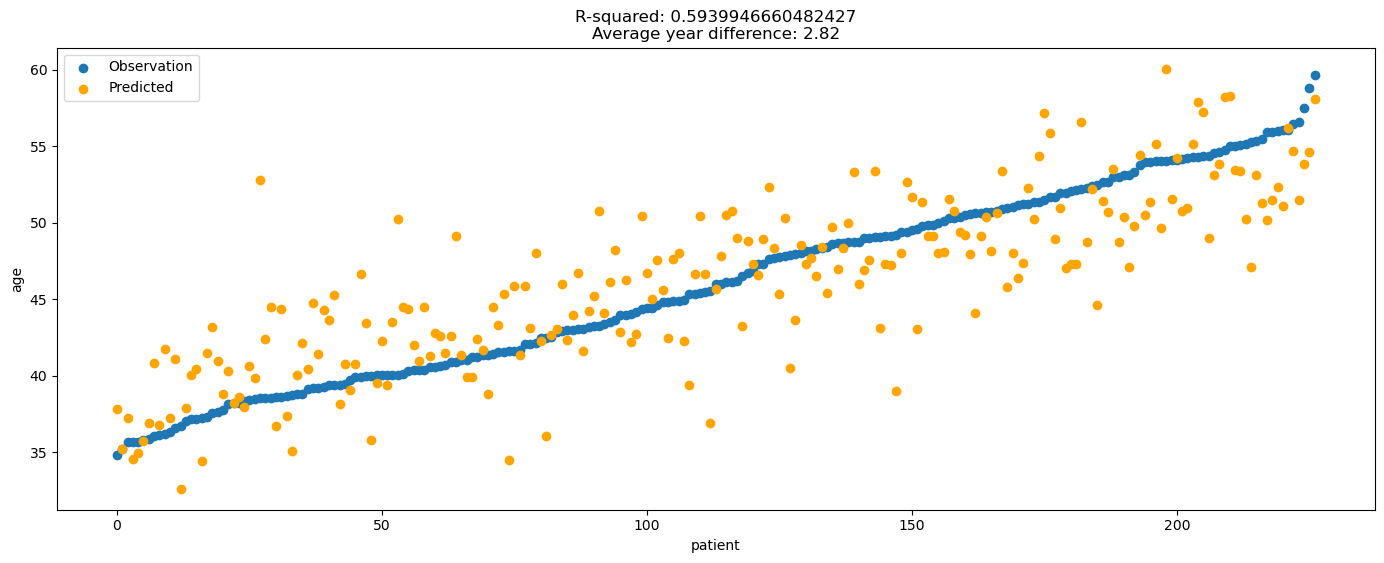

In [265]:
# params = {
#     # 'cv':[2, 4, 6],
#     'alphas':range(20)
# }

# model = RandomizedSearchCV(RidgeCV(), params).fit(x_train,y_train)
# print(model.best_params_)

params = {'alphas': 19}
model = RidgeCV(**params)
model.fit(x_train,y_train)

y_pred = model.predict(x_val)
r2_train = r2_score(model.predict(x_train), y_train)
r2_test = r2_score(y_pred, y_val)

print('R-squared on traindata:',r2_train)
print('R-squared on testdata:',r2_test)
validation_plot(y_pred, y_val)

In [266]:
#concatenating and keeping the same order of indices as from y_val
val_ages = pd.DataFrame(age.iloc[y_val.index])
val_delta = pd.concat([val_ages.reset_index(drop=True), pd.DataFrame(y_pred).reset_index(drop=True)],
                       axis = 1, ignore_index=True)
val_delta.columns = ['True age', 'Predicted age']
val_delta['Delta'] = val_delta['Predicted age'] - val_delta['True age']
print(np.mean(val_delta['Delta']))


0.14916679241609207


In [267]:
IMTdata = Meta[['IMTCLMAX', 'IMTCRMAX', 'IMTFLMAX', 'IMTFRMAX']]
IMTdata = IMTdata.fillna(0)
IMTdata['maxIMT'] = IMTdata[['IMTCLMAX', 'IMTCRMAX', 'IMTFLMAX', 'IMTFRMAX']].max(axis=1)
IMTdata = IMTdata.drop(['IMTCLMAX', 'IMTCRMAX', 'IMTFLMAX', 'IMTFRMAX'], axis=1)

In [268]:
val_IMT = IMTdata.iloc[y_val.index]
val_delta = pd.concat([val_delta.reset_index(drop=True), val_IMT.reset_index(drop=True)],
                       axis = 1, ignore_index=True)
val_delta.columns = ['True age', 'Predicted age', 'Delta', 'maxIMT']

In [269]:
val_delta_meta = pd.concat([val_delta.reset_index(drop=True), Meta.iloc[y_val.index].reset_index(drop=True)],
                       axis = 1, ignore_index=True)
val_delta_meta.columns = list(val_delta.columns) + list(Meta.columns)

In [270]:
from scipy.stats import pearsonr

colnames_new = []
p_vec = []
pval_vec = []
delta = val_delta_meta['Delta']
data = val_delta_meta.iloc[:, val_delta_meta.columns != 'Delta']

for i in np.arange(0, len(data.columns)):
    predictor = data.iloc[:, i]
    non_nan_idx = ~predictor.isna()
    predictor = predictor[non_nan_idx]
    delta_filtered = delta[non_nan_idx]

    if len(delta_filtered) >= 2 and len(predictor) >= 2:
        uniques = predictor.unique()

        # check if all values are numeric, then calculate pearson correlation
        if all((np.issubdtype(type(x), np.integer) or np.issubdtype(type(x), np.floating)) for x in uniques):

            pearson_corr, pval = pearsonr(delta_filtered, predictor)
            if not np.isnan(pearson_corr):
                p_vec.append(pearson_corr)
                pval_vec.append(pval)
                colnames_new.append(data.columns[i])


metadata = pd.DataFrame({'Pearson Correlation':p_vec, 'P-value': pval_vec, 'Predictor':colnames_new})
metadata = metadata.iloc[np.abs(metadata['Pearson Correlation']).argsort()[::-1]].reset_index(drop=True)

# outputting the 10 highest correlated predictors:  
metadata.iloc[0:25]

# meanTC: Total Cholesterol
# meanSBP: Systolic Blood Pressure 
# CarotidIMT/ IMTCL: Carotid Intima-Media Thickness (Carotid Left?)
# atherokappa2: kappa index for interobserver agreement on the presence of plaques ≥ 4 (?) mm thick: https://www.nejm.org/doi/full/10.1056/NEJM199412013312202

# Note:
# S0: "scleral invasion not assessed"(not interesting since not biological)


c:\Users\jeppe\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,Pearson Correlation,P-value,Predictor
0,-0.443980,2.207213e-12,AGESQUARE
1,-0.441735,2.929463e-12,True age
2,-0.441735,2.929463e-12,Age_years
3,-0.429361,1.344610e-11,Agetruehalfdecade
4,-0.420436,8.609618e-11,AtheroMS_1
5,-0.382996,2.406722e-09,S0
6,-0.302344,3.498401e-06,meanTC
7,-0.275361,2.582591e-05,TMA
8,0.271799,3.312109e-05,TMEAR
9,0.271753,3.304504e-03,AfnameUur


# Removing "bad" batches

In [271]:
SOMAMeta = pd.read_csv('SOMAMeta.csv',low_memory=False)
SOMAMeta['VisitB_Date'] = pd.to_datetime(SOMAMeta['VisitB_Date'])
months_to_remove = [4, 5, 6, 7]  # April, May, June, July
SOMAMeta_filtered = SOMAMeta[~((SOMAMeta['VisitB_Date'].dt.year == 2003) & 
                               (SOMAMeta['VisitB_Date'].dt.month.isin(months_to_remove)))]
SOMAMeta_filtered.loc[:, 'VisitB_Date'] = pd.to_numeric(SOMAMeta_filtered['VisitB_Date'], errors='coerce')

C:\Users\jeppe\AppData\Local\Temp\ipykernel_3008\1581321451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOMAMeta_filtered.loc[:, 'VisitB_Date'] = pd.to_numeric(SOMAMeta_filtered['VisitB_Date'], errors='coerce')


In [272]:
Meta = SOMAMeta_filtered[SOMAMeta.columns[:1005]].reset_index(drop=True)
SOMA = SOMAMeta_filtered[SOMAMeta.columns[1005:]].reset_index(drop=True)
age = SOMAMeta_filtered['Age_years'].reset_index(drop=True)

In [273]:
colnames = SOMA.columns
p_vec = []

for i in range(len(colnames)):
    pearson_corr = np.corrcoef(age, SOMA.iloc[:, i])[0, 1]
    p_vec.append(pearson_corr)

df = pd.DataFrame({'Pearson Correlation':p_vec, 'Predictor':colnames})
df = df.iloc[np.abs(df['Pearson Correlation']).argsort()[::-1]]

In [274]:
df.head

<bound method NDFrame.head of       Pearson Correlation      Predictor
4844             0.392028    seq.3032.11
6908            -0.362789    seq.8841.65
4800             0.351893    seq.2953.31
1171             0.325940   seq.13101.60
4288            -0.309642   seq.24679.35
...                   ...            ...
1221             0.000033  seq.13406.161
4638            -0.000029    seq.2614.28
2378            -0.000016    seq.18297.8
699             -0.000010   seq.11989.35
3453             0.000002    seq.2192.63

[7523 rows x 2 columns]>

select n best predictors

In [275]:
n = 300
selectedP = SOMAMeta_filtered[df.iloc[0:n,1].reset_index(drop=True)]
#selectedP = SOMA.copy()

x_train, x_val, y_train, y_val = train_test_split(
    selectedP, 
    age, 
    test_size=0.2, 
    random_state=42,
    stratify=Meta['Ever_smokers']
)

x_train = standardise(x_train)
x_val = standardise(x_val)

Lasso

R-squared on traindata: 0.3818402279293779
R-squared on testdata: 0.2693957791665694


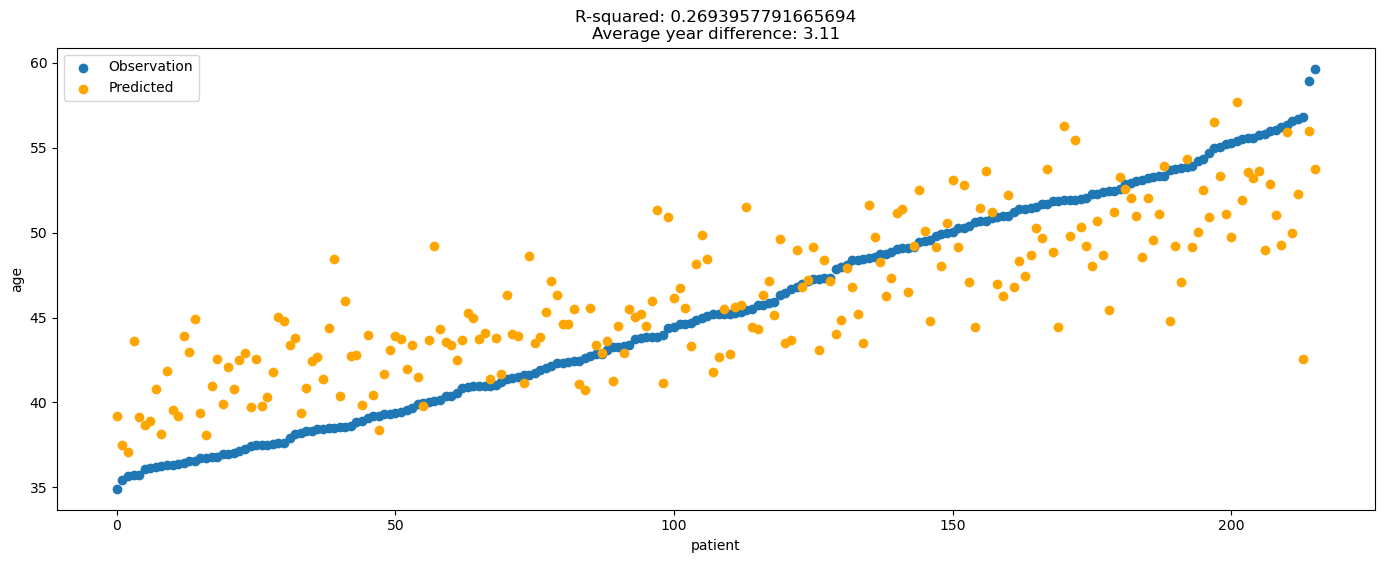

In [276]:
model = LassoCV(cv=4, max_iter=10000, n_alphas=4).fit(x_train, y_train)


y_pred = model.predict(x_val)
r2_train = r2_score(model.predict(x_train), y_train)
r2_test = r2_score(y_pred, y_val)

print('R-squared on traindata:',r2_train)
print('R-squared on testdata:',r2_test)
validation_plot(y_pred, y_val)

Ridge

c:\Users\jeppe\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'alphas': 38}
R-squared on traindata: 0.7892178096199062
R-squared on testdata: 0.6367387816409755


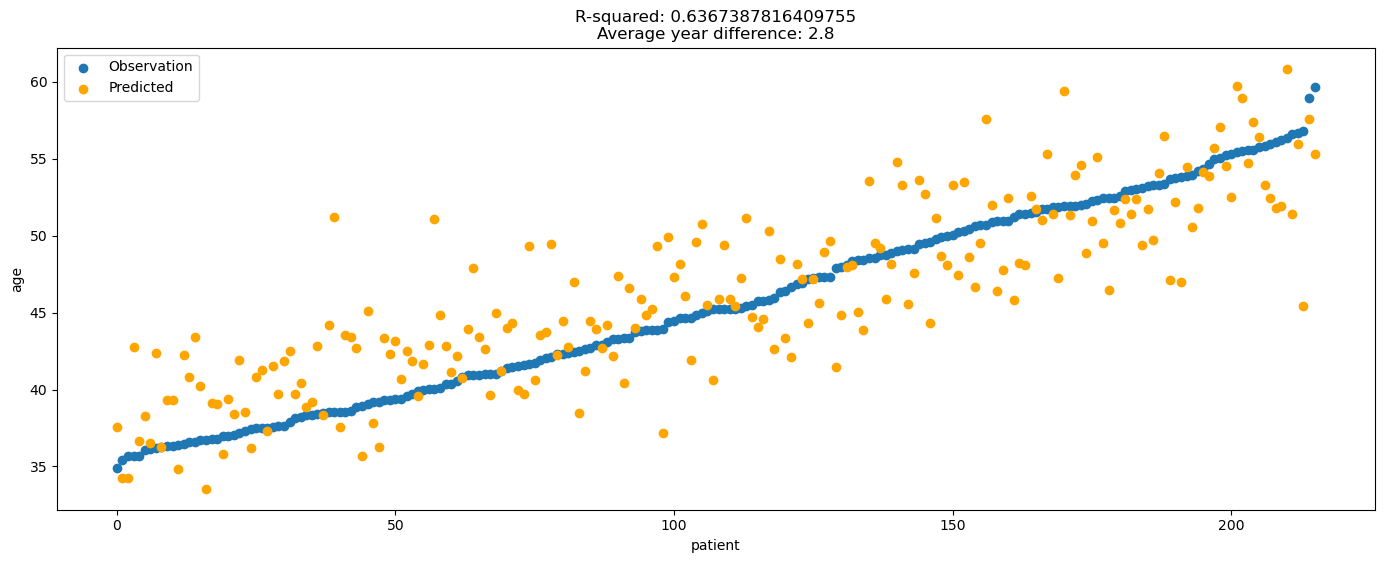

In [277]:
params = {
    # 'cv':[2, 4, 6],
    'alphas':[38]
}
model = RandomizedSearchCV(RidgeCV(), params).fit(x_train,y_train)
print(model.best_params_)

# params = {'alphas': 99}
# model = LassoCV(**params)
# model.fit(x_train,y_train)

y_pred = model.predict(x_val)
r2_train = r2_score(model.predict(x_train), y_train)
r2_test = r2_score(y_pred, y_val)

print('R-squared on traindata:',r2_train)
print('R-squared on testdata:',r2_test)
validation_plot(y_pred, y_val)  

In [278]:
#concatenating and keeping the same order of indices as from y_val
val_ages = pd.DataFrame(age.iloc[y_val.index])
val_delta = pd.concat([val_ages.reset_index(drop=True), pd.DataFrame(y_pred).reset_index(drop=True)],
                       axis = 1, ignore_index=True)
val_delta.columns = ['True age', 'Predicted age']
val_delta['Delta'] = val_delta['Predicted age'] - val_delta['True age']
print(np.mean(abs(val_delta['Delta'])))


2.798730190813842


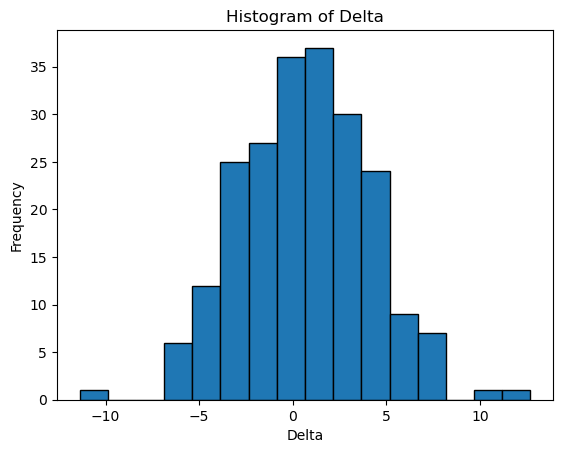

In [299]:
plt.hist(val_delta['Delta'], bins=16, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Delta')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.show()



In [280]:
IMTdata = Meta[['IMTCLMAX', 'IMTCRMAX', 'IMTFLMAX', 'IMTFRMAX']]
IMTdata = IMTdata.fillna(0)
IMTdata['maxIMT'] = IMTdata[['IMTCLMAX', 'IMTCRMAX', 'IMTFLMAX', 'IMTFRMAX']].max(axis=1)
IMTdata = IMTdata.drop(['IMTCLMAX', 'IMTCRMAX', 'IMTFLMAX', 'IMTFRMAX'], axis=1)

In [281]:
val_IMT = IMTdata.iloc[y_val.index]
val_delta = pd.concat([val_delta.reset_index(drop=True), val_IMT.reset_index(drop=True)],
                       axis = 1, ignore_index=True)
val_delta.columns = ['True age', 'Predicted age', 'Delta', 'maxIMT']

In [282]:
val_delta_meta = pd.concat([val_delta.reset_index(drop=True), Meta.iloc[y_val.index].reset_index(drop=True)],
                       axis = 1, ignore_index=True)
val_delta_meta.columns = list(val_delta.columns) + list(Meta.columns)

In [283]:
val_delta_meta['gender'] = val_delta_meta['Gender'].map({'M': 0, 'F': 1})

C:\Users\jeppe\AppData\Local\Temp\ipykernel_3008\546101827.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_delta_meta['gender'] = val_delta_meta['Gender'].map({'M': 0, 'F': 1})


In [284]:
from scipy.stats import pearsonr
from statsmodels.stats import multitest

colnames_new = []
p_vec = []
pval_vec = []
delta = val_delta_meta['Delta']
data = val_delta_meta.iloc[:, val_delta_meta.columns != 'Delta']

for i in np.arange(0, len(data.columns)):
    predictor = data.iloc[:, i]
    non_nan_idx = ~predictor.isna()
    predictor = predictor[non_nan_idx]
    delta_filtered = delta[non_nan_idx]

    if len(delta_filtered) >= 2 and len(predictor) >= 2:
        uniques = predictor.unique()

        # check if all values are numeric, then calculate pearson correlation
        if all((np.issubdtype(type(x), np.integer) or np.issubdtype(type(x), np.floating)) for x in uniques):

            pearson_corr, pval = pearsonr(delta_filtered, predictor)
            if not np.isnan(pearson_corr):
                p_vec.append(pearson_corr)
                pval_vec.append(pval)
                colnames_new.append(data.columns[i])


metadata = pd.DataFrame({'Predictor':colnames_new, 'Pearson Correlation':p_vec, 'P-value': pval_vec})
metadata = metadata.iloc[np.abs(metadata['Pearson Correlation']).argsort()[::-1]].reset_index(drop=True)

reject, corrected_pvals, _, _ = multitest.multipletests(metadata['P-value'], method='fdr_bh')
metadata['Corrected P-value'] = corrected_pvals
metadata['Reject Null Hypothesis'] = reject

metadata = metadata.iloc[metadata['Corrected P-value'].argsort()].reset_index(drop=True)
# outputting the 10 highest correlated predictors:  

metadata.iloc[0:25]
significant = metadata[(metadata['Reject Null Hypothesis'] == True)]
significant = significant[~significant['Predictor'].str.contains('age|Age|AGE|S0')]
significant.reset_index(drop=True)

# meanTC: Total Cholesterol
# meanSBP: Systolic Blood Pressure 
# CarotidIMT/ IMTCL: Carotid Intima-Media Thickness (Carotid Left?)
# atherokappa2: kappa index for interobserver agreement on the presence of plaques ≥ 4 (?) mm thick: https://www.nejm.org/doi/full/10.1056/NEJM199412013312202

# Note:
# S0: "scleral invasion not assessed"(not interesting since not biological)


c:\Users\jeppe\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,Predictor,Pearson Correlation,P-value,Corrected P-value,Reject Null Hypothesis
0,AtheroMS_1,-0.380383,1.449858e-08,0.000003,True
1,meanTC,-0.317066,1.973203e-06,0.000243,True
2,TTORefl,0.248035,3.035353e-04,0.032744,True


In [298]:
metadata[(metadata['Predictor'].str.contains('smokers|Body|gender|IMT[C|F][L|R]$|maxIMT|BP_mmHg|$alcohol$|sportFREQ'))].reset_index(drop=True)

,Predictor,Pearson Correlation,P-value,Corrected P-value,Reject Null Hypothesis
0,IMTCL,-0.157359,0.020684,0.285535,False
1,IMTCR,-0.146112,0.031836,0.306930,False
2,IMTFL,-0.147974,0.033787,0.306930,False
3,maxIMT,-0.130720,0.055076,0.356768,False
4,sportFREQ,0.127266,0.061879,0.374750,False
5,Ever_smokers,-0.067030,0.326831,0.622307,False
6,IMTFR,-0.062834,0.368416,0.655553,False
7,gender,-0.059297,0.385841,0.664632,False
8,Systolic_BP_mmHg,-0.047175,0.490394,0.732197,False
9,Diastolic_BP_mmHg,0.013796,0.840238,0.914169,False
